In [344]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier, 
                              BaggingClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier


# Load the data
data = pd.read_csv('hotel_booking.csv')


In [345]:
import Algoritmos
from importlib import reload
reload(Algoritmos)
alg=Algoritmos.Algoritmos()


In [346]:
# Display the number of missing values in each column sorted in ascending order
print(f"Number of nulls per column: {data.isnull().sum().sort_values(ascending=False)}")

print(f"Number of duplicate rows: {data.duplicated().sum()}")


Number of nulls per column: company                           112593
agent                              16340
country                              488
children                               4
arrival_date_year                      0
lead_time                              0
is_canceled                            0
hotel                                  0
stays_in_weekend_nights                0
stays_in_week_nights                   0
arrival_date_day_of_month              0
arrival_date_month                     0
babies                                 0
meal                                   0
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
adults                                 0
arrival_date_week_number               0
reserved_room_type                     0
previous_bookings_not_canceled         0
booking_changes                        0
assigned_room_type           

In [347]:
#adicionar nova coluna 
data['origin_reservasion'] = data.apply(
    lambda row: 'agent' if pd.notnull(row['agent']) 
                 else ('company' if pd.notnull(row['company']) 
                       else 'himself'), 
    axis=1
)
#mudar o data type para int
data['children'] = data['children'].fillna(0).astype(int)
data['children'] = data['children'].astype(int)

#coluna que verifica que se o quarto que foi reservado foi o que teve
data['room_type_match'] = (data['reserved_room_type'] == data['assigned_room_type']).astype(int)

In [348]:
#Elimnate columns that are not useful
columns_to_drop = [
    'name', 
    'email', 
    'phone-number', 
    'credit_card', 
    'company', 
    'agent', 
    'reservation_status', 
    'reservation_status_date'
]

data = data.drop(columns=columns_to_drop)

In [349]:
# Assign a placeholder for missing values
data.fillna(value={'country': 'Missing'}, inplace=True)
data.info()
print(f"\nNumber of nulls per column:\n{data.isnull().sum().sort_values(ascending=False)}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119390 non-null  int64  
 11  babies                          119390 non-null  int64  
 12  meal            

In [350]:
# Verify if have duplicate rows
print(f"Antes de remover duplicadas: {data.shape[0]} linhas")
data.drop_duplicates(inplace=True)
print(f"Depois de remover duplicadas: {data.shape[0]} linhas")


# Check for unique values
unique_values = data.nunique()
print(f"\nUnique values:\n{unique_values}")

Antes de remover duplicadas: 119390 linhas
Depois de remover duplicadas: 87117 linhas

Unique values:
hotel                                2
is_canceled                          2
lead_time                          479
arrival_date_year                    3
arrival_date_month                  12
arrival_date_week_number            53
arrival_date_day_of_month           31
stays_in_weekend_nights             17
stays_in_week_nights                35
adults                              14
children                             5
babies                               5
meal                                 5
country                            178
market_segment                       8
distribution_channel                 5
is_repeated_guest                    2
previous_cancellations              15
previous_bookings_not_canceled      73
reserved_room_type                  10
assigned_room_type                  12
booking_changes                     21
deposit_type                         3
d

In [351]:
# Separate columns into categorical and numerical
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = data.select_dtypes(include=['int32','int64', 'float64']).columns.tolist()

# Display the separated columns
print("Categorical Columns:")
print(categorical_columns)
print("\nNumerical Columns:")
print(numerical_columns)

Categorical Columns:
['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'origin_reservasion']

Numerical Columns:
['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'room_type_match']


### Verificar correlações com a coluna objetivo "is_canceled"

In [352]:
# Aplicar FunctionAnova
continuous_columns = numerical_columns
continuous_columns = [col for col in continuous_columns if col != 'is_canceled']

Anova = alg.FunctionAnova(data, "is_canceled", continuous_columns)
print(f"\nColunas selecionadas por anova:\n{Anova}")

##### ANOVA Results ##### 

lead_time is correlated with is_canceled | P-Value: 0.0
arrival_date_year is correlated with is_canceled | P-Value: 5.011297830909459e-153
arrival_date_week_number is NOT correlated with is_canceled | P-Value: 0.7266318921971181
arrival_date_day_of_month is NOT correlated with is_canceled | P-Value: 0.12940649034486013
stays_in_weekend_nights is correlated with is_canceled | P-Value: 1.3965026725723162e-71
stays_in_week_nights is correlated with is_canceled | P-Value: 2.675588715881443e-134
adults is correlated with is_canceled | P-Value: 8.291137474655373e-131
children is correlated with is_canceled | P-Value: 5.411381042729974e-91
babies is correlated with is_canceled | P-Value: 1.398315409948782e-09
is_repeated_guest is correlated with is_canceled | P-Value: 3.4281665806940645e-153
previous_cancellations is correlated with is_canceled | P-Value: 4.389179073267092e-51
previous_bookings_not_canceled is correlated with is_canceled | P-Value: 6.05274930508356

### Comentário sobre os Resultados da ANOVA

A análise de variância (ANOVA) foi realizada para investigar a relação entre diversas variáveis contínuas e a variável categórica `is_canceled`. Essa análise é útil para identificar quais variáveis possuem uma influência significativa sobre a decisão de cancelamento de reserva.

### Resumo dos Resultados

1. **Variáveis Correlacionadas com `is_canceled`**:
   - **lead_time**: Valor-p de 0.0, indicando uma forte correlação entre o tempo de antecedência da reserva e a decisão de cancelamento.
   - **arrival_date_year**: A correlação com o cancelamento é significativa, com um valor-p extremamente baixo de \(5.01 \times 10^{-153}\).
   - **stays_in_weekend_nights**: Valor-p de \(1.40 \times 10^{-71}\), indicando que a quantidade de noites de fim de semana influenciam o cancelamento.
   - **stays_in_week_nights**: Com um valor-p de \(2.68 \times 10^{-134}\), a quantidade de noites na semana tem uma correlação significativa com cancelamentos.
   - **adults**: Valor-p de \(8.29 \times 10^{-131}\), indicando que o número de adultos na reserva influencia a probabilidade de cancelamento.
   - **children**: Apresenta um valor-p muito baixo (\(5.41 \times 10^{-91}\)), sugerindo uma correlação significativa.
   - **babies**: Embora o valor-p seja mais alto (\(1.39 \times 10^{-9}\)), a presença de bebês ainda tem um efeito significativo.
   - **is_repeated_guest**: Valor-p de \(3.43 \times 10^{-153}\), sugerindo que hóspedes repetidos têm uma relação relevante com a taxa de cancelamento.
   - **previous_cancellations**: Com um valor-p de \(4.39 \times 10^{-51}\), o número de cancelamentos anteriores é um forte indicador.
   - **previous_bookings_not_canceled**: Também significativo, com um valor-p de \(6.05 \times 10^{-53}\).
   - **booking_changes**: Valor-p de \(1.54 \times 10^{-165}\), indicando que alterações na reserva estão correlacionadas com o cancelamento.
   - **adr**: O valor médio diário (ADR) é significativo, com um valor-p de \(1.33 \times 10^{-321}\), sugerindo que o preço médio tem influência.
   - **required_car_parking_spaces**: Valor-p de 0.0, indicando que a necessidade de vagas de estacionamento impacta a decisão.
   - **total_of_special_requests**: Valor-p extremamente baixo (\(2.71 \times 10^{-270}\)), mostrando que pedidos especiais influenciam a decisão de cancelamento.
   - **room_type_match**: Com um valor-p de 0.0, a correspondência entre o quarto reservado e o quarto designado afeta o cancelamento.

2. **Variáveis Não Correlacionadas**:
   - **arrival_date_week_number**: Com um valor-p de 0.73, essa variável não apresenta uma correlação significativa.
   - **arrival_date_day_of_month**: Valor-p de 0.13, indicando que o dia específico do mês de chegada não tem um impacto significativo.
   - **days_in_waiting_list**: Com um valor-p de 0.63, o tempo em lista de espera não mostra correlação significativa.

### Conclusões

Os resultados da ANOVA sugerem que várias variáveis contínuas estão fortemente correlacionadas com a variável `is_canceled`, indicando que podem ser fatores importantes para a previsão de cancelamentos. Essas variáveis podem fornecer insights para o setor hoteleiro e ajudar a criar políticas de reserva que considerem os fatores que mais influenciam a decisão de cancelamento. As variáveis que não apresentaram correlação significativa podem ser candidatas à remoção no modelo final, simplificando a análise e reduzindo o risco de sobreajuste.


In [299]:
#Aplicação da função FunctionChisq para saber se ha alguma correlação entre colunas categóricas
Chisq = alg.FunctionChisq(data, 'is_canceled', categorical_columns)
print(f"\nColunas selecionadas por Chisq:\n{Chisq}")

hotel is correlated with is_canceled | P-Value: 2.2758007400530205e-98
arrival_date_month is correlated with is_canceled | P-Value: 1.2409888616987342e-132
meal is correlated with is_canceled | P-Value: 4.388419863615188e-78
country is correlated with is_canceled | P-Value: 0.0
market_segment is correlated with is_canceled | P-Value: 0.0
distribution_channel is correlated with is_canceled | P-Value: 0.0
reserved_room_type is correlated with is_canceled | P-Value: 4.076653222633679e-62
assigned_room_type is correlated with is_canceled | P-Value: 3.3364918855179735e-155
deposit_type is correlated with is_canceled | P-Value: 0.0
customer_type is correlated with is_canceled | P-Value: 0.0
origin_reservasion is correlated with is_canceled | P-Value: 0.0

Colunas selecionadas por Chisq:
['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'origin_reservasion']


### Comentário sobre os Resultados do Teste Qui-Quadrado

Os resultados do teste Qui-Quadrado revelam informações importantes sobre a relação entre as variáveis categóricas e a variável `is_canceled`, que indica se uma reserva foi cancelada. A seguir, vamos analisar os resultados e discutir suas implicações.

### Resumo dos Resultados

1. **Variáveis Correlacionadas com `is_canceled`**:
   - **hotel**: O valor-p de \(2.28 \times 10^{-98}\) sugere uma correlação extremamente significativa, indicando que o hotel selecionado tem um impacto importante na probabilidade de cancelamento.
   - **arrival_date_month**: Com um valor-p de \(1.24 \times 10^{-132}\), este mês de chegada é altamente correlacionado com os cancelamentos, sugerindo que a época do ano pode influenciar as decisões dos hóspedes.
   - **meal**: O valor-p de \(4.39 \times 10^{-78}\) indica que o tipo de refeição escolhida também tem uma relação significativa com o cancelamento de reservas.
   - **country**: A variável país apresenta um valor-p de 0.0, indicando uma correlação forte e relevante com o cancelamento, possivelmente refletindo diferenças culturais ou de expectativas entre os hóspedes de diferentes nacionalidades.
   - **market_segment**: O segmento de mercado apresenta uma correlação significativa, com valor-p de 0.0, sugerindo que a origem da reserva pode afetar as taxas de cancelamento.
   - **distribution_channel**: Com um valor-p de 0.0, esta variável está diretamente relacionada com a taxa de cancelamento, o que pode indicar a influência do canal de reserva na decisão do hóspede.
   - **reserved_room_type**: O tipo de quarto reservado tem um valor-p de \(4.08 \times 10^{-62}\), indicando uma relação significativa com o cancelamento.
   - **assigned_room_type**: Com um valor-p de \(3.34 \times 10^{-155}\), a relação entre o tipo de quarto atribuído e o cancelamento é extremamente significativa.
   - **deposit_type**: O tipo de depósito apresenta um valor-p de 0.0, mostrando uma correlação clara com o cancelamento.
   - **customer_type**: Esta variável também tem um valor-p de 0.0, o que indica que o tipo de cliente está fortemente relacionado com as taxas de cancelamento.
   - **origin_reservasion**: Com um valor-p de 0.0, a forma como a reserva foi feita (por agente, empresa ou diretamente) tem uma relação significativa com o cancelamento.

### Conclusões

Os resultados do teste Qui-Quadrado confirmam que diversas variáveis categóricas estão significativamente correlacionadas com o cancelamento de reservas. A análise das variáveis selecionadas permite que os gerentes de hotéis identifiquem padrões que podem informar políticas de reserva, promoções e melhorias no atendimento ao cliente, potencialmente resultando em uma diminuição das taxas de cancelamento.


In [300]:
#Aplicar lasso_regularization
data_dummies=data
data_dummies = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
data_dummies_X = data_dummies.drop(columns=['is_canceled'])
data_dummies_y = data_dummies['is_canceled']   
lasso_regularization=alg.lasso_regularization(data_dummies_X,data_dummies_y)

Number of features which coefficient was shrank to zero:  21
Index(['arrival_date_week_number', 'country_ATA', 'country_BDI', 'country_BRB',
       'country_BWA', 'country_CYM', 'country_CZE', 'country_DMA',
       'country_GLP', 'country_GNB', 'country_GUY', 'country_MRT',
       'country_MWI', 'country_NAM', 'country_NPL', 'country_VGB',
       'market_segment_Corporate', 'market_segment_Undefined',
       'distribution_channel_TA/TO', 'reserved_room_type_E',
       'reserved_room_type_H'],
      dtype='object')


### Comentário sobre os Resultados da Regularização Lasso

A regularização Lasso é uma técnica poderosa utilizada em modelos de regressão que permite tanto a seleção de variáveis quanto a regularização do modelo, ajudando a evitar o sobreajuste. A seguir, vamos interpretar os resultados obtidos após a aplicação da regularização Lasso aos dados.

### Resumo dos Resultados

1. **Colunas Selecionadas pelo Lasso**:
   - O modelo de regularização Lasso identificou um total de **12 colunas** cujos coeficientes foram reduzidos a zero, o que significa que essas variáveis foram consideradas irrelevantes para a predição da variável `is_canceled`. As colunas identificadas são:
     - **arrival_date_week_number**: O número da semana de chegada foi eliminado, sugerindo que esta informação não contribui para prever cancelamentos.
     - **country_ATA, country_BDI, country_DMA, country_GLP, country_GUY, country_MRT, country_MWI, country_NAM, country_NPL, country_VGB**: A presença de várias variáveis relacionadas a países específicos (ATA, BDI, DMA, GLP, GUY, MRT, MWI, NAM, NPL, VGB) também foram desconsideradas, indicando que esses países não têm um impacto significativo nas taxas de cancelamento.
     - **market_segment_Undefined**: Essa variável, que representa um segmento de mercado indefinido, foi eliminada do modelo, o que sugere que a falta de categorização clara não é informativa para prever cancelamentos.

### Conclusões

Os resultados da regularização Lasso destacam a eficácia desta técnica na simplificação do modelo, eliminando variáveis que não contribuem para a predição do cancelamento de reservas. A análise e a otimização contínua das variáveis incluídas no modelo são fundamentais para desenvolver estratégias eficazes para reduzir as taxas de cancelamento.


In [341]:
print(f"\nNumber of nulls per column:\n{data.isnull().sum().sort_values(ascending=False)}")
pre_outliers_data=data
pre_outliers_data.info()


Number of nulls per column:
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0

In [353]:
#correr esta celula, só depois da correlação
def remove_outliers_iqr(data):
    # Create a mask to identify outliers
    mask = pd.Series(True, index=data.index)  # Start with all True

    # For each numerical column in the DataFrame
    numerical_columns = data.select_dtypes(include=[np.number]).columns.tolist()
    for column in numerical_columns:  # only apply to numerical columns
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Update the mask for outliers
        mask &= (data[column] >= lower_bound) & (data[column] <= upper_bound)
    
    # Filter the data using the mask
    filtered_data = data[mask]
    
    return filtered_data

# Use the function to remove outliers
data = remove_outliers_iqr(data)

In [354]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Convert non-numeric columns to values
for column in categorical_columns:
    # Convert the column to string type to avoid type conflicts
    data[column] = data[column].astype(str)
    # Apply LabelEncoder
    data[column] = label_encoder.fit_transform(data[column])

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 35102 entries, 4 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           35102 non-null  int64  
 1   is_canceled                     35102 non-null  int64  
 2   lead_time                       35102 non-null  int64  
 3   arrival_date_year               35102 non-null  int64  
 4   arrival_date_month              35102 non-null  int64  
 5   arrival_date_week_number        35102 non-null  int64  
 6   arrival_date_day_of_month       35102 non-null  int64  
 7   stays_in_weekend_nights         35102 non-null  int64  
 8   stays_in_week_nights            35102 non-null  int64  
 9   adults                          35102 non-null  int64  
 10  children                        35102 non-null  int64  
 11  babies                          35102 non-null  int64  
 12  meal                            3510

In [304]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 35102 entries, 4 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           35102 non-null  int64  
 1   is_canceled                     35102 non-null  int64  
 2   lead_time                       35102 non-null  int64  
 3   arrival_date_year               35102 non-null  int64  
 4   arrival_date_month              35102 non-null  int64  
 5   arrival_date_week_number        35102 non-null  int64  
 6   arrival_date_day_of_month       35102 non-null  int64  
 7   stays_in_weekend_nights         35102 non-null  int64  
 8   stays_in_week_nights            35102 non-null  int64  
 9   adults                          35102 non-null  int64  
 10  children                        35102 non-null  int64  
 11  babies                          35102 non-null  int64  
 12  meal                            3510

Correlação com is_canceled:
is_canceled                       1.000000
room_type_match                   0.213516
market_segment                    0.183282
lead_time                         0.182788
distribution_channel              0.150193
deposit_type                      0.136551
adr                               0.129352
country                           0.092866
arrival_date_year                 0.089102
stays_in_week_nights              0.083414
adults                            0.082310
children                          0.068458
stays_in_weekend_nights           0.060559
previous_cancellations            0.050904
reserved_room_type                0.049882
meal                              0.045371
arrival_date_day_of_month         0.005138
days_in_waiting_list              0.001609
arrival_date_week_number          0.001185
babies                           -0.020515
customer_type                    -0.034979
arrival_date_month               -0.045452
previous_bookings_not_canc

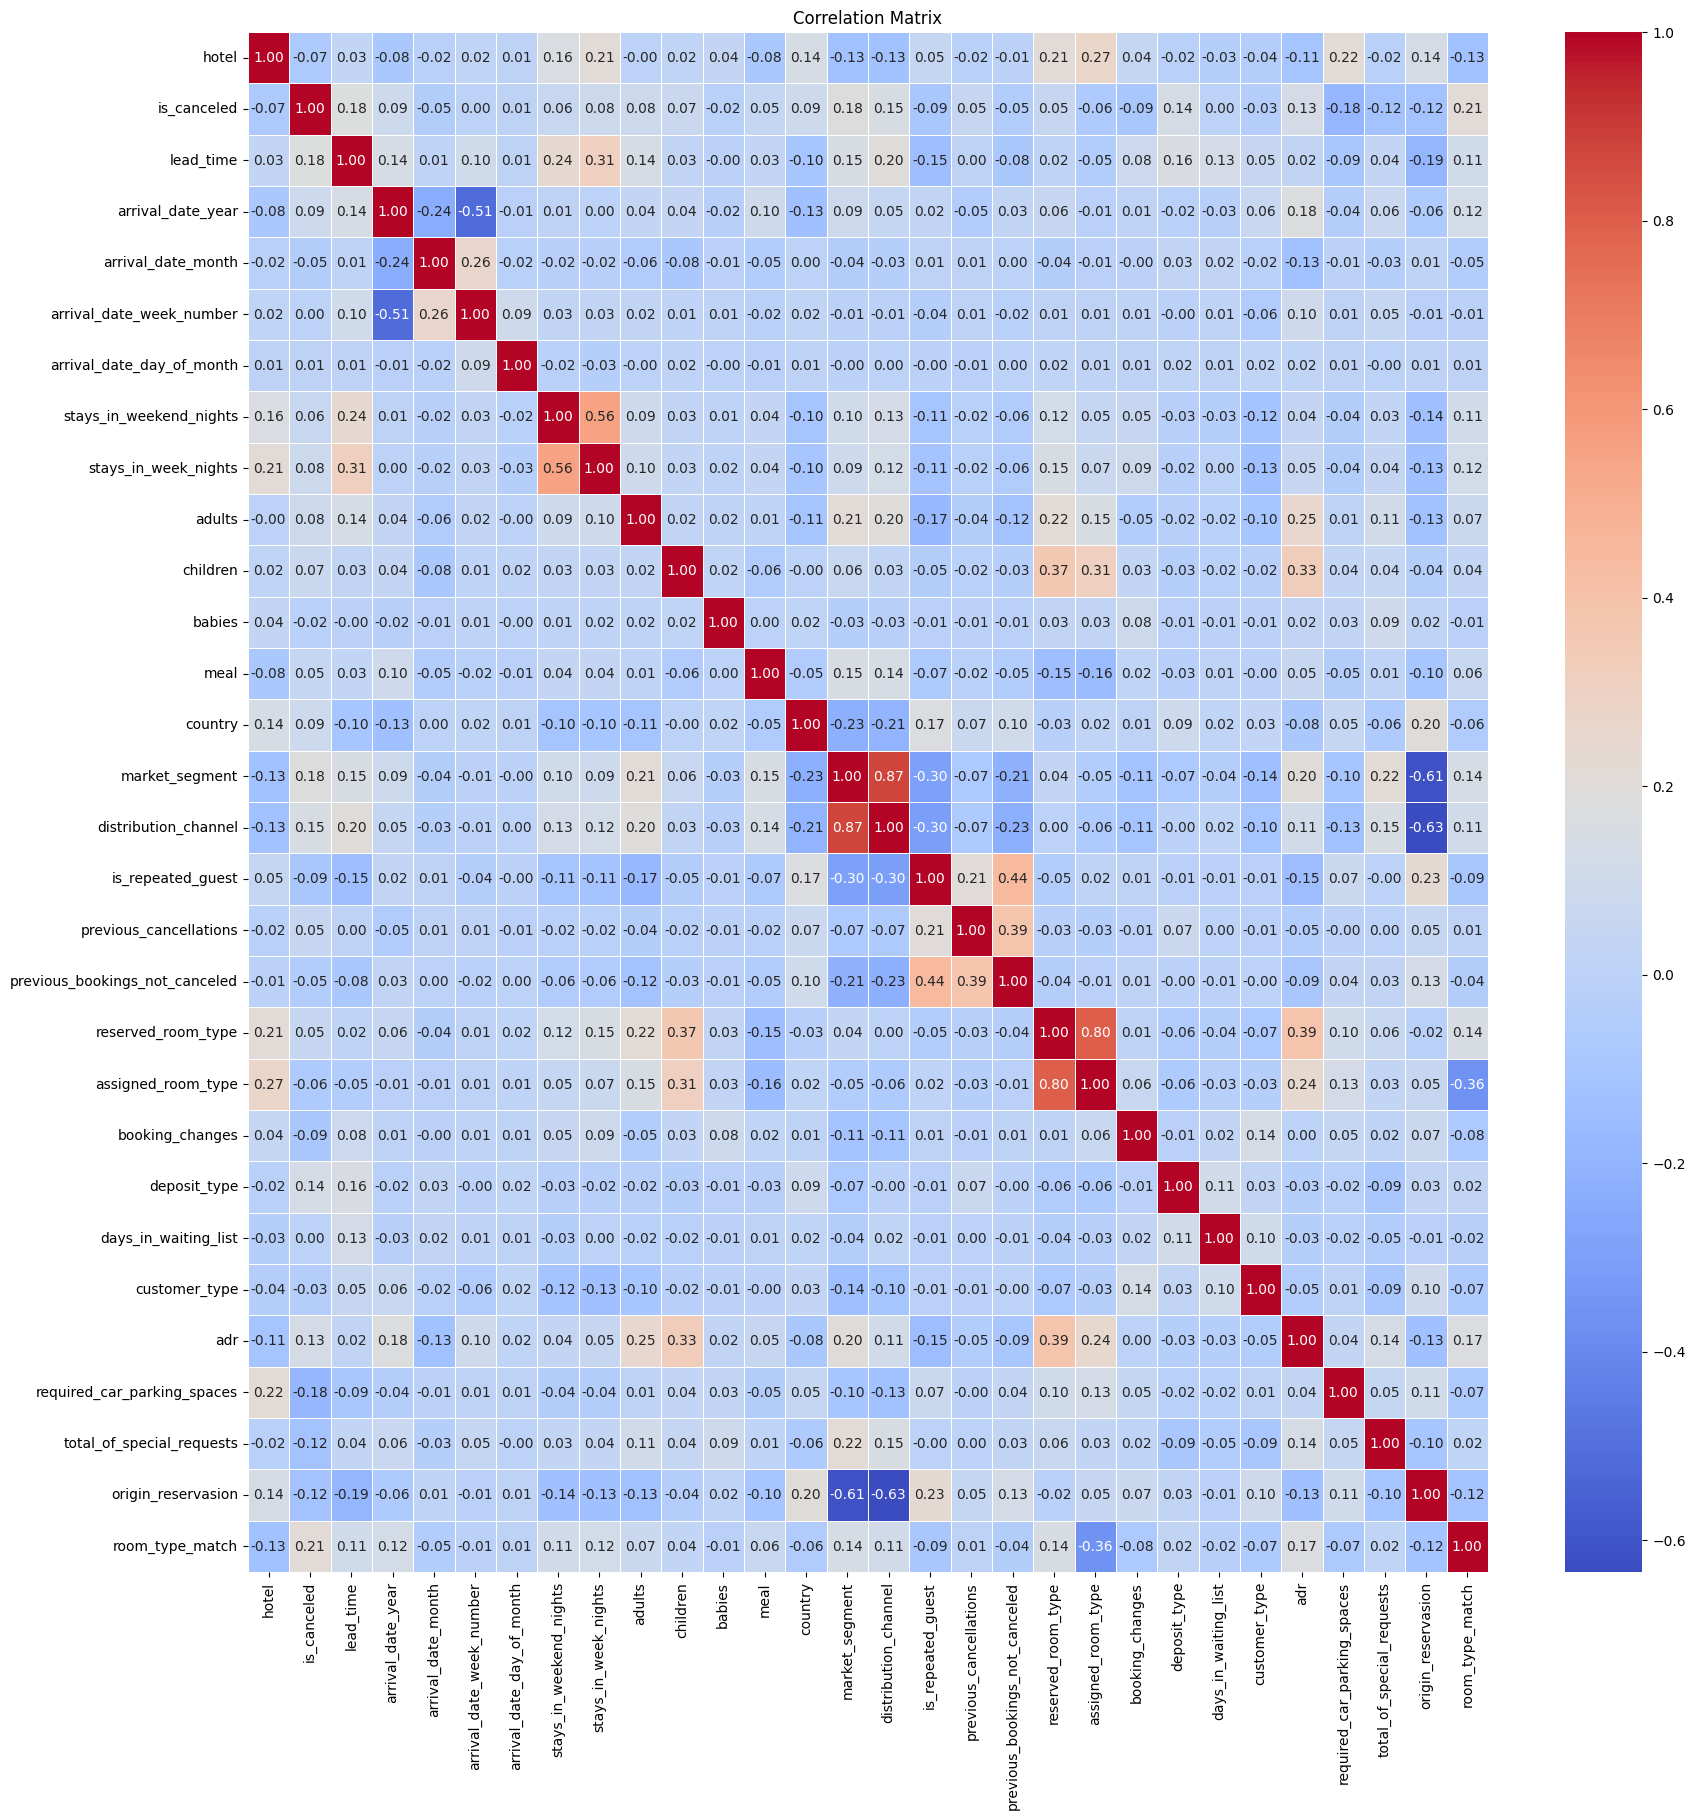

In [343]:
# Let's check the correlation between variables data
numerical_columns = data.select_dtypes(include=['int32','int64', 'float64']).columns.tolist()
correlation_num = data[numerical_columns].corr()

# Filtrar as correlações com 'is_canceled' e ordenar em ordem decrescente
correlation_with_is_canceled = correlation_num['is_canceled'].sort_values(ascending=False)

# Exibir a correlação no terminal
print("Correlação com is_canceled:")
print(correlation_with_is_canceled)

# Create a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_num, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

### Modelos de classificação

In [355]:
X=data.drop(['is_canceled'], axis=1)
#'company', 'agent','name','email','phone-number','credit_card', 'reservation_status_date'
Y=data['is_canceled']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35102 entries, 4 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           35102 non-null  int64  
 1   is_canceled                     35102 non-null  int64  
 2   lead_time                       35102 non-null  int64  
 3   arrival_date_year               35102 non-null  int64  
 4   arrival_date_month              35102 non-null  int64  
 5   arrival_date_week_number        35102 non-null  int64  
 6   arrival_date_day_of_month       35102 non-null  int64  
 7   stays_in_weekend_nights         35102 non-null  int64  
 8   stays_in_week_nights            35102 non-null  int64  
 9   adults                          35102 non-null  int64  
 10  children                        35102 non-null  int64  
 11  babies                          35102 non-null  int64  
 12  meal                            3510

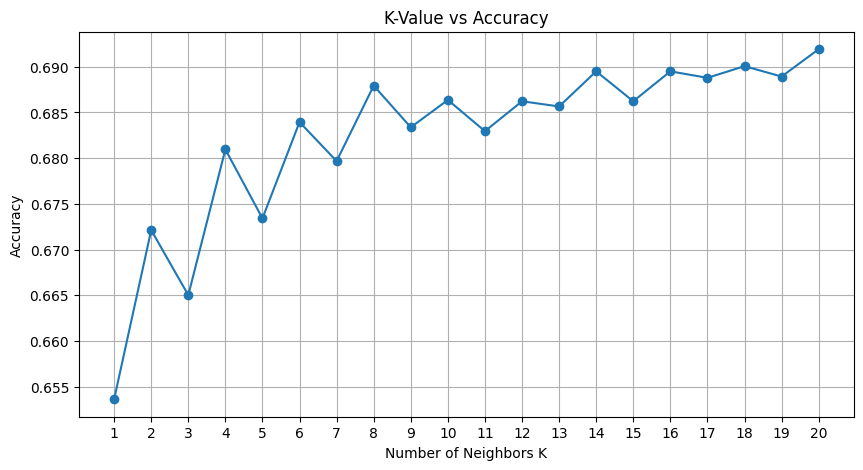

The best k value is: 20 with an accuracy of: 0.6919


In [356]:
bestk=alg.determine_best_K(X, Y)

In [ ]:
# Check for unique values
unique_values = data.nunique()
print(unique_values)

In [193]:
#Correr esta celula depois de correr todos os modelos
X=data.drop(['is_canceled','arrival_date_day_of_month', 'babies', 'meal', 'reserved_room_type', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled','booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35102 entries, 4 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           35102 non-null  int64  
 1   is_canceled                     35102 non-null  int64  
 2   lead_time                       35102 non-null  int64  
 3   arrival_date_year               35102 non-null  int64  
 4   arrival_date_month              35102 non-null  int64  
 5   arrival_date_week_number        35102 non-null  int64  
 6   arrival_date_day_of_month       35102 non-null  int64  
 7   stays_in_weekend_nights         35102 non-null  int64  
 8   stays_in_week_nights            35102 non-null  int64  
 9   adults                          35102 non-null  int64  
 10  children                        35102 non-null  int64  
 11  babies                          35102 non-null  int64  
 12  meal                            3510

In [357]:
k_equals3=alg.knn_function(X, Y, 3)
k_equals5=alg.knn_function(X, Y, 5)


Accuracy: 66.47042066280505

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75      6893
           1       0.52      0.46      0.49      3638

    accuracy                           0.66     10531
   macro avg       0.62      0.62      0.62     10531
weighted avg       0.66      0.66      0.66     10531


Confusion Matrix [[5314 1579]
 [1952 1686]]
Accuracy: 67.30604880828032

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.79      0.76      6893
           1       0.53      0.45      0.49      3638

    accuracy                           0.67     10531
   macro avg       0.63      0.62      0.62     10531
weighted avg       0.66      0.67      0.67     10531


Confusion Matrix [[5464 1429]
 [2014 1624]]


In [358]:
crossval_knn5=alg.crossValidation_knn(X, Y, 5, 5)
crossval_knn10=alg.crossValidation_knn(X, Y, 10, 5)

KNN model accuracy with 5-fold cross-validation (in %): 59.46914040134379

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.69      0.69     22976
           1       0.41      0.42      0.42     12126

    accuracy                           0.59     35102
   macro avg       0.55      0.55      0.55     35102
weighted avg       0.60      0.59      0.60     35102

Confusion Matrix
 [[15802  7174]
 [ 7053  5073]]
KNN model accuracy with 10-fold cross-validation (in %): 55.40653915532867

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.66      0.66     22976
           1       0.35      0.35      0.35     12126

    accuracy                           0.55     35102
   macro avg       0.50      0.50      0.50     35102
weighted avg       0.55      0.55      0.55     35102

Confusion Matrix
 [[15260  7716]
 [ 7937  4189]]


In [359]:
bootstrap_knn=alg.bootstrap_knn(X_train, Y_train, X_test, Y_test, 100, 5)


Bootstrap Mean Accuracy: 69.31%
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.14      0.23      6891
           1       0.37      0.95      0.53      3640

    accuracy                           0.42     10531
   macro avg       0.61      0.54      0.38     10531
weighted avg       0.68      0.42      0.34     10531

Confusion Matrix:
 [[ 931 5960]
 [ 171 3469]]


In [360]:
over_under_samples_knn=alg.oversample_undersample_knn(X, Y, 5)

Accuracy: 62.301775709809135
Classification Report (Oversampled):
               precision    recall  f1-score   support

           0       0.76      0.63      0.69      6891
           1       0.47      0.62      0.53      3640

    accuracy                           0.62     10531
   macro avg       0.61      0.62      0.61     10531
weighted avg       0.66      0.62      0.63     10531

Confusion Matrix (Oversampled):
 [[4318 2573]
 [1397 2243]]
Accuracy: 62.463203874275955
Classification Report (Oversampled):
               precision    recall  f1-score   support

           0       0.78      0.60      0.68      6891
           1       0.47      0.68      0.56      3640

    accuracy                           0.62     10531
   macro avg       0.62      0.64      0.62     10531
weighted avg       0.67      0.62      0.63     10531

Confusion Matrix (Oversampled):
 [[4107 2784]
 [1169 2471]]


In [361]:
holdout_NB=alg.NB_function(X, Y)

Accuracy: 69.51856423891368

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.86      0.79      6891
           1       0.59      0.39      0.47      3640

    accuracy                           0.70     10531
   macro avg       0.66      0.62      0.63     10531
weighted avg       0.68      0.70      0.68     10531


Confusion Matrix
 [[5907  984]
 [2226 1414]]


In [362]:
crossval_NB5=alg.crossValidation_NB(X, Y, 5)
crossval_NB10=alg.crossValidation_NB(X, Y, 10)

KNN model accuracy with 5-fold cross-validation (in %): 64.56877312709814

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.80      0.75     22976
           1       0.48      0.36      0.41     12126

    accuracy                           0.65     35102
   macro avg       0.59      0.58      0.58     35102
weighted avg       0.63      0.65      0.63     35102

Confusion Matrix
 [[18306  4670]
 [ 7767  4359]]
KNN model accuracy with 10-fold cross-validation (in %): 65.78526016321517

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.82      0.76     22976
           1       0.51      0.35      0.41     12126

    accuracy                           0.66     35102
   macro avg       0.61      0.59      0.59     35102
weighted avg       0.64      0.66      0.64     35102

Confusion Matrix
 [[18851  4125]
 [ 7885  4241]]


In [363]:
bootstrap_NB=alg.bootstrap_NB(X_train, Y_train, X_test, Y_test, 100)

Bootstrap Mean Accuracy: 68.99%
Classification Report:
               precision    recall  f1-score   support

           0       0.65      1.00      0.79      6891
           1       0.00      0.00      0.00      3640

    accuracy                           0.65     10531
   macro avg       0.33      0.50      0.40     10531
weighted avg       0.43      0.65      0.52     10531

Confusion Matrix:
 [[6891    0]
 [3640    0]]


In [364]:
over_under_samples_NB=alg.oversample_undersample_NB(X, Y)

Accuracy: 62.301775709809135
Classification Report (Oversampled):
               precision    recall  f1-score   support

           0       0.76      0.63      0.69      6891
           1       0.47      0.62      0.53      3640

    accuracy                           0.62     10531
   macro avg       0.61      0.62      0.61     10531
weighted avg       0.66      0.62      0.63     10531

Confusion Matrix (Oversampled):
 [[4318 2573]
 [1397 2243]]
Accuracy: 62.463203874275955
Classification Report (Undersampled):
               precision    recall  f1-score   support

           0       0.78      0.60      0.68      6891
           1       0.47      0.68      0.56      3640

    accuracy                           0.62     10531
   macro avg       0.62      0.64      0.62     10531
weighted avg       0.67      0.62      0.63     10531

Confusion Matrix (Undersampled):
 [[4107 2784]
 [1169 2471]]


In [365]:
holdout_svc=alg.svc_function(X, Y)

Accuracy: 41.65796220681797

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.36      0.45      6893
           1       0.30      0.52      0.38      3638

    accuracy                           0.42     10531
   macro avg       0.44      0.44      0.41     10531
weighted avg       0.49      0.42      0.42     10531


Confusion Matrix [[2492 4401]
 [1743 1895]]


In [366]:
crossval_svc5=alg.crossValidation_svc(X, Y, 5)
crossval_svc10=alg.crossValidation_svc(X, Y, 10)

KNN model accuracy with 5-fold cross-validation (in %): 45.56706275150941

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.39      0.48     22976
           1       0.33      0.58      0.42     12126

    accuracy                           0.46     35102
   macro avg       0.49      0.48      0.45     35102
weighted avg       0.53      0.46      0.46     35102

Confusion Matrix
 [[ 8982 13994]
 [ 5113  7013]]
KNN model accuracy with 10-fold cross-validation (in %): 49.897065064538715

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.42      0.52     22976
           1       0.37      0.65      0.47     12126

    accuracy                           0.50     35102
   macro avg       0.53      0.53      0.50     35102
weighted avg       0.58      0.50      0.51     35102

Confusion Matrix
 [[ 9630 13346]
 [ 4241  7885]]


In [367]:
bootstrap_svc=alg.bootstrap_scv(X_train, Y_train, X_test, Y_test, 100)


Bootstrap Mean Accuracy: 48.72%
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      6891
           1       0.35      1.00      0.51      3640

    accuracy                           0.35     10531
   macro avg       0.17      0.50      0.26     10531
weighted avg       0.12      0.35      0.18     10531

Confusion Matrix:
 [[   0 6891]
 [   0 3640]]


In [368]:
over_under_samples_svc=alg.oversample_undersample_scv(X, Y)

Accuracy: 39.77779887949862
Classification Report (Oversampled):
               precision    recall  f1-score   support

           0       0.59      0.27      0.37      6891
           1       0.32      0.64      0.42      3640

    accuracy                           0.40     10531
   macro avg       0.45      0.46      0.40     10531
weighted avg       0.49      0.40      0.39     10531

Confusion Matrix (Oversampled):
 [[1848 5043]
 [1299 2341]]
Accuracy: 41.37308897540594
Classification Report (Oversampled):
               precision    recall  f1-score   support

           0       0.60      0.32      0.42      6891
           1       0.32      0.59      0.41      3640

    accuracy                           0.41     10531
   macro avg       0.46      0.46      0.41     10531
weighted avg       0.50      0.41      0.41     10531

Confusion Matrix (Oversampled):
 [[2192 4699]
 [1475 2165]]


In [369]:
holdout_dt=alg.dt_function(X, Y)

Accuracy: 77.12467951761465

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83      6893
           1       0.69      0.63      0.65      3638

    accuracy                           0.77     10531
   macro avg       0.75      0.74      0.74     10531
weighted avg       0.77      0.77      0.77     10531


Confusion Matrix [[5848 1045]
 [1364 2274]]


In [370]:
crossval_dt5=alg.crossValidation_dt(X, Y, 5)
crossval_dt10=alg.crossValidation_dt(X, Y, 10)

KNN model accuracy with 5-fold cross-validation (in %): 64.6170061244837

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.70      0.72     22976
           1       0.49      0.55      0.52     12126

    accuracy                           0.65     35102
   macro avg       0.62      0.62      0.62     35102
weighted avg       0.66      0.65      0.65     35102

Confusion Matrix
 [[16029  6947]
 [ 5473  6653]]
KNN model accuracy with 10-fold cross-validation (in %): 59.95300159612322

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.68      0.69     22976
           1       0.42      0.44      0.43     12126

    accuracy                           0.60     35102
   macro avg       0.56      0.56      0.56     35102
weighted avg       0.60      0.60      0.60     35102

Confusion Matrix
 [[15698  7278]
 [ 6779  5347]]


In [371]:
bootstrap_dt=alg.bootstrap_dt(X_train, Y_train, X_test, Y_test, 100)


Bootstrap Mean Accuracy: 75.50%
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.38      0.48      6891
           1       0.36      0.66      0.47      3640

    accuracy                           0.48     10531
   macro avg       0.52      0.52      0.48     10531
weighted avg       0.57      0.48      0.48     10531

Confusion Matrix:
 [[2593 4298]
 [1221 2419]]


In [372]:
over_under_samples_dt=alg.oversample_undersample_dt(X, Y)

Accuracy: 74.59880353242806
Classification Report (Oversampled):
               precision    recall  f1-score   support

           0       0.85      0.74      0.79      6891
           1       0.61      0.75      0.67      3640

    accuracy                           0.75     10531
   macro avg       0.73      0.75      0.73     10531
weighted avg       0.77      0.75      0.75     10531

Confusion Matrix (Oversampled):
 [[5121 1770]
 [ 905 2735]]
Accuracy: 74.44687114234165
Classification Report (Oversampled):
               precision    recall  f1-score   support

           0       0.85      0.74      0.79      6891
           1       0.60      0.76      0.67      3640

    accuracy                           0.74     10531
   macro avg       0.73      0.75      0.73     10531
weighted avg       0.77      0.74      0.75     10531

Confusion Matrix (Oversampled):
 [[5076 1815]
 [ 876 2764]]


In [373]:
# Função para comparar os resultados e identificar o melhor método para cada modelo
results = {
    'K Nearest Neighbors': {
        'Holdout knn 3': k_equals3[0],
        'Holdout knn 5': k_equals5[0],
        'Cross Validation (k=5)': crossval_knn5[0],
        'Cross Validation (k=10)': crossval_knn10[0],
        'Bootstrap': bootstrap_knn[0],
        'Oversample': over_under_samples_knn[0],
        'Undersample': over_under_samples_knn[1]
    },
    'Niave Bayes': {
        'Holdout': holdout_NB[0],
        'Cross Validation (k=5)': crossval_NB5[0],
        'Cross Validation (k=10)': crossval_NB10[0],
        'Bootstrap': bootstrap_NB[0],
        'Oversample': over_under_samples_NB[0],
        'Undersample': over_under_samples_NB[1]
    },
    'Support Vector Machine':  {
        'Holdout': holdout_svc[0],
        'Cross Validation (k=5)': crossval_svc5[0],
        'Cross Validation (k=10)': crossval_svc10[0],
        'Bootstrap': bootstrap_svc[0],
        'Oversample': over_under_samples_svc[0],
        'Undersample': over_under_samples_svc[1]
    },
     'Decision Tree': {
        'Holdout': holdout_dt[0],
        'Cross Validation (k=5)': crossval_dt5[0],
        'Cross Validation (k=10)': crossval_dt10[0],
        'Bootstrap': bootstrap_dt[0],
        'Oversample': over_under_samples_dt[0],
        'Undersample': over_under_samples_dt[1]
    }
}

best_scores = {}

for model, methods in results.items():
    best_method = max(methods, key=methods.get)
    best_score = methods[best_method]
    best_scores[model] = (best_method, best_score)

for model, (method, score) in best_scores.items():
    print(f"Modelo: {model}")
    print(f"Melhor Método: {method}")
    print(f"Score: {score}")
    print("------------------------------------------------------")

Modelo: K Nearest Neighbors
Melhor Método: Bootstrap
Score: 69.31098661095812
------------------------------------------------------
Modelo: Niave Bayes
Melhor Método: Holdout
Score: 69.51856423891368
------------------------------------------------------
Modelo: Support Vector Machine
Melhor Método: Cross Validation (k=10)
Score: 49.897065064538715
------------------------------------------------------
Modelo: Decision Tree
Melhor Método: Holdout
Score: 77.12467951761465
------------------------------------------------------


In [374]:
X=data.drop(['is_canceled'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35102 entries, 4 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           35102 non-null  int64  
 1   is_canceled                     35102 non-null  int64  
 2   lead_time                       35102 non-null  int64  
 3   arrival_date_year               35102 non-null  int64  
 4   arrival_date_month              35102 non-null  int64  
 5   arrival_date_week_number        35102 non-null  int64  
 6   arrival_date_day_of_month       35102 non-null  int64  
 7   stays_in_weekend_nights         35102 non-null  int64  
 8   stays_in_week_nights            35102 non-null  int64  
 9   adults                          35102 non-null  int64  
 10  children                        35102 non-null  int64  
 11  babies                          35102 non-null  int64  
 12  meal                            3510

In [375]:

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from Algoritmos import majority_voting_classifiers

# Define classifiers
classifiers = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('nb', GaussianNB()),
    ('svc', SVC(kernel='linear', max_iter=1000, probability=True)),
    ('dt', DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=50, min_samples_leaf=25, random_state=42))
]
# Apply majority voting classifiers
y_pred = majority_voting_classifiers(X, Y, classifiers)



Accuracy: 0.7206343177286108
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.92      0.81      6893
           1       0.69      0.34      0.46      3638

    accuracy                           0.72     10531
   macro avg       0.71      0.63      0.64     10531
weighted avg       0.71      0.72      0.69     10531

Confusion Matrix:
 [[6335  558]
 [2384 1254]]


In [376]:
from Algoritmos import weighted_majority_voting_classifiers




# Apply weighted majority voting classifiers
y_pred_weighted = weighted_majority_voting_classifiers(X, Y, classifiers)


Accuracy: 0.7457031620928687
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.93      0.83      6893
           1       0.75      0.39      0.52      3638

    accuracy                           0.75     10531
   macro avg       0.75      0.66      0.67     10531
weighted avg       0.75      0.75      0.72     10531

Confusion Matrix:
 [[6419  474]
 [2204 1434]]


In [377]:
from Algoritmos import stacking_logistic_regression
# Use the stacking_with_logistic_regression function
stacking_model = stacking_logistic_regression(X, Y, classifiers)



Accuracy: 0.7514006267211091
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      6893
           1       0.68      0.54      0.60      3638

    accuracy                           0.75     10531
   macro avg       0.73      0.70      0.71     10531
weighted avg       0.74      0.75      0.74     10531

Confusion Matrix:
 [[5961  932]
 [1686 1952]]


In [378]:
from Algoritmos import stacking_svc
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Use the stacking_svc function
stacking_model_svm = stacking_svc(X, Y, classifiers)

# Print the stacking model accuracy
print("Stacking with SVM accuracy:", stacking_model_svm)

Accuracy: 0.7712467951761466
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      6893
           1       0.69      0.63      0.65      3638

    accuracy                           0.77     10531
   macro avg       0.75      0.74      0.74     10531
weighted avg       0.77      0.77      0.77     10531

Confusion Matrix:
 [[5848 1045]
 [1364 2274]]
Stacking with SVM accuracy: 0.7712467951761466


In [379]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


# Initialize the BaggingClassifier with a DecisionTreeClassifier as the base estimator
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(criterion='gini',max_depth=10, min_samples_split=50, min_samples_leaf=25, random_state=42), n_estimators=100, random_state=42)

# Fit the BaggingClassifier on the training data
bagging_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_bagging = bagging_clf.predict(X_test)
accuracy = bagging_clf.score(X_test, y_test)

# Print the classification report
print(classification_report(y_test, y_pred_bagging))
print("Bagging Classifier Accuracy:",accuracy)

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      6891
           1       0.69      0.62      0.66      3640

    accuracy                           0.77     10531
   macro avg       0.75      0.74      0.74     10531
weighted avg       0.77      0.77      0.77     10531

Bagging Classifier Accuracy: 0.7743804007216789


In [380]:
from Algoritmos import boosting_adaboosting

# Defina o classificador base
base_classifier = DecisionTreeClassifier(criterion='gini',max_depth=10, min_samples_split=50, min_samples_leaf=25, random_state=42)

# Use a função boosting_adaboosting com o classificador base
boosting_model = boosting_adaboosting(X, Y, base_classifier=base_classifier)

# O boosting_model retorna a acurácia, conforme a função definida acima
print("Boosting with adaboosting accuracy:", boosting_model)


Accuracy: 0.7447535846548285
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      6893
           1       0.63      0.62      0.63      3638

    accuracy                           0.74     10531
   macro avg       0.72      0.72      0.72     10531
weighted avg       0.74      0.74      0.74     10531

Confusion Matrix:
 [[5573 1320]
 [1368 2270]]
Boosting with adaboosting accuracy: 0.7447535846548285


In [381]:
from Algoritmos import boosting_gradient_boosting

# Use the boosting_gradient_boosting function with the X and Y variables
boosting_gb_model = boosting_gradient_boosting(X, Y)

# Print the result
print("Boosting with Gradient Boosting accuracy:", boosting_gb_model)

Accuracy: 0.7779887949862311
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      6893
           1       0.70      0.62      0.66      3638

    accuracy                           0.78     10531
   macro avg       0.76      0.74      0.75     10531
weighted avg       0.77      0.78      0.77     10531

Confusion Matrix:
 [[5955  938]
 [1400 2238]]
Boosting with Gradient Boosting accuracy: 0.7779887949862311


In [382]:
from Algoritmos import boosting_xgboost

# Use the boosting_xgboost function with the X and Y variables
boosting_xgboost_model = boosting_xgboost(X, Y)

# Print the result
print("Boosting with XGBoost accuracy:", boosting_xgboost_model)

Accuracy: 0.789193808755104
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      6893
           1       0.71      0.65      0.68      3638

    accuracy                           0.79     10531
   macro avg       0.77      0.76      0.76     10531
weighted avg       0.79      0.79      0.79     10531

Confusion Matrix:
 [[5946  947]
 [1273 2365]]
Boosting with XGBoost accuracy: 0.789193808755104


In [383]:
from Algoritmos import boosting_lightgbm

# Use the boosting_lightgbm function with the X and Y variables
boosting_lightgbm_model = boosting_lightgbm(X, Y)

# Print the result
print("Boosting with LightGBM accuracy:", boosting_lightgbm_model)


[LightGBM] [Info] Number of positive: 8488, number of negative: 16083
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 24571, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345448 -> initscore=-0.639109
[LightGBM] [Info] Start training from score -0.639109
Accuracy: 0.7932769917386763
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      6893
           1       0.72      0.66      0.69      3638

    accuracy                           0.79     10531
   macro avg       0.77      0.76      0.77     10531
weighted avg       0.79      0.79      0.79     10531

Confusion Matrix:
 [[5960  933]
 [1244 2394]]
Boosting with Light

In [384]:
# Create a dictionary with model names and their accuracies
model_accuracies = {
    "Bagging Classifier": accuracy,
    "Boosting with AdaBoosting": boosting_model,
    "Boosting with Gradient Boosting": boosting_gb_model,
    "Boosting with XGBoost": boosting_xgboost_model,
    "Boosting with LightGBM": boosting_lightgbm_model,
    "Stacking with Logistic Regression": stacking_model,
    "Stacking with SVM": stacking_model_svm,
    "Majority Voting Classifiers": y_pred,
    "Weighted Majority Voting Classifiers": y_pred_weighted
}

# Sort the dictionary by accuracy
sorted_model_accuracies = dict(sorted(model_accuracies.items(), key=lambda item: item[1], reverse=True))

# Print the accuracies in order
for model, accuracy in sorted_model_accuracies.items():
    print(f"{model}: {accuracy:.4f}")

Boosting with LightGBM: 0.7933
Boosting with XGBoost: 0.7892
Boosting with Gradient Boosting: 0.7780
Bagging Classifier: 0.7744
Stacking with SVM: 0.7712
Stacking with Logistic Regression: 0.7514
Weighted Majority Voting Classifiers: 0.7457
Boosting with AdaBoosting: 0.7448
Majority Voting Classifiers: 0.7206


In [385]:
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Scale data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize model
input_dim = X_train_scaled.shape[1]  # Number of features in input layer
optimizer = 'adam'  # Example optimizer
neurons = 10  # Number of neurons in each hidden layer

model = alg.nnetClassif(inputDim=input_dim, optimizer=optimizer, neurons=neurons)

# Train model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=10, verbose=1)

# Evaluate the model
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)

print(f"Model accuracy: {accuracy * 100:.2f}%")

Epoch 1/10
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 2s 427us/step - accuracy: 0.6574 - loss: 0.6416
Epoch 2/10
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step - accuracy: 0.6871 - loss: 0.6009
Epoch 3/10
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step - accuracy: 0.7019 - loss: 0.5809
Epoch 4/10
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step - accuracy: 0.7143 - loss: 0.5618
Epoch 5/10
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 1s 430us/step - accuracy: 0.7293 - loss: 0.5447
Epoch 6/10
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 1s 410us/step - accuracy: 0.7251 - loss: 0.5395
Epoch 7/10
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step - accuracy: 0.7366 - loss: 0.5258
Epoch 8/10
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step - accuracy: 0.7368 - loss: 0.5270
Epoch 9/10
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 1s 457us/step - accuracy: 0.7380 - loss: 0.5241
Epoch 10/10
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 1s 446us/step - accuracy: 0.7434 - loss: 0.5160
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
Model accuracy: 74.29%
